In [450]:
%matplotlib inline

import copy
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.stats as stats
import gensim
import networkx
from sklearn import preprocessing

In [2]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'

In [3]:
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [277]:
def connected_word_list(seed_word, keyed_vectors, n_iterations=5):
    all_words = [seed_word]
    for i in range(n_iterations):
        seed_word = random.sample(all_words, 1)
        nearest_neighbors = list(np.array(keyed_vectors.most_similar(seed_word))[:, 0])
        all_words += nearest_neighbors
    return all_words

In [119]:
def semantic_dsm(word_list, keyed_vectors):
    vectors = np.array([keyed_vectors.word_vec(word) for word in word_list])
    return dist.pdist(vectors, metric='cosine')

In [127]:
def plot_labeled_matrix(matrix, labels=None):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots()
        plt.imshow(
            matrix, 
            cmap='viridis', 
            vmin=np.min(matrix), 
            vmax=np.max(matrix)
        )
        if labels is not None:
            ax.set_yticklabels(labels)
            ax.set_yticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=30)
            ax.set_xticks(range(len(labels)))
        plt.colorbar()

In [96]:
def make_probability_distribution(v):
    return v / np.sum(v)

In [506]:
def xcal_like(x, t1=.25, t2=.5, t3=1.0, min_adjust=-.05, max_adjust=.05):
    """Given an activation strength, return how to adjust the association strength."""
    xp = [0, t1, t2, t3]
    fp = [0, min_adjust, 0, max_adjust]
    return np.interp(x, xp, fp, left=0, right=max_adjust)

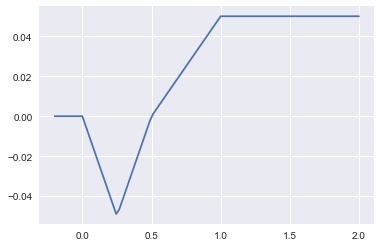

In [507]:
xs = np.linspace(-.2, 2, 100)
plt.plot(xs, xcal_like(xs))

In [508]:
class SemanticGraph(object):
    def __init__(self, adj=None, labels=None, word_dsm=None):
        if word_dsm is None:
            self.adj = adj
        else:
            assert word_dsm.shape[0] == word_dsm.shape[1]
            word_adj = 1 - word_dsm
            np.fill_diagonal(word_adj, 0)
            #self.adj = np.apply_along_axis(make_probability_distribution, axis=1, arr=word_adj)
            self.adj = word_adj
        self.labels = labels
        
    def query(self, word):
        """Given a word or word index, return a randomly selected connected node.
        The probability distribution for the selection is derived from the adjacency matrix.        
        Like a word association task. A winner-take-all query with no spreading activation (i.e., depth=1).
        """
        if type(word) is int:
            word_i = word
        elif type(word) is str:
            word_i = self.labels.index(word)
        else:
            raise TypeError("word must be str or int (for a word index)")
        
        probs = self.adj[word_i]
        distrib = stats.rv_discrete(values=(range(len(probs)), probs))
        return_ix = distrib.rvs(size=1)[0]
        return_word = self.labels[return_ix]
        
        self.modify_edge(word, return_word, strength=.01)
        
        return (return_word, return_ix)
    
    def activate(self, word_from, strength=1.0, decay=.8, lower_threshold=.1, new_adj=None):
        """Spread activation through the network, adjusting synaptic weights."""
        print("{0} at strength {1}".format(word_from, strength))

        if new_adj is None:
            new_adj = copy.copy(self.adj)
        
        word_from_i = self.labels.index(word_from)
        next_layer_activations = new_adj[word_from_i] * decay
        print(next_layer_activations)
        
        # Prevent loops by zeroing out weights back to already-activated nodes
        new_adj[:, word_from_i] = 0
        new_adj[:, np.array(next_layer_activations) > lower_threshold] = 0

        for word_to_i, activation in enumerate(next_layer_activations):
            # Update edge weights
            self.adj[word_from_i, word_to_i] += xcal_like(activation)
            if self.adj[word_from_i, word_to_i] > 1:
                self.adj[word_from_i, word_to_i] = 1
            if self.adj[word_from_i, word_to_i] < 0:
                self.adj[word_from_i, word_to_i] = 0
            
            if activation > lower_threshold:
                self.activate(self.labels[word_to_i], strength=activation, new_adj=new_adj)
         
    def modify_edge(self, word_from, word_to, strength=.01):
        """Percentage change in edge weight from one word to another.
        
        Not necessary when using similarity for weights (instead of a probability distribution).
        """
        ix_from = self.labels.index(word_from)
        ix_to = self.labels.index(word_to)
        
        strength_decrement = strength / (self.adj.shape[0] - 2) # minus one for the self-connection
                                                                # minus one for the connection to-be-strengthened
        
        probs = self.adj[ix_from]
        for i, prob in enumerate(probs):
            if i == ix_from or i == ix_to:
                pass
            else:
                probs[i] -= strength_decrement
        probs[ix_to] += strength

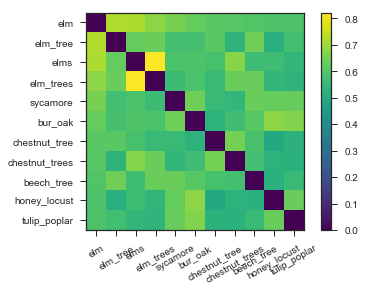

In [519]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

## Spreading activation and weight updating

### Activating one word over and over again

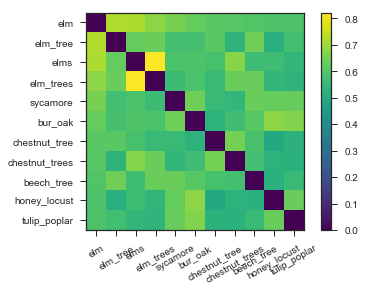

In [525]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

In [526]:
for i in range(20):
    g.activate('elm')

elm at strength 1.0
[ 0.          0.57848651  0.57661122  0.543446    0.52184537  0.50241122
  0.48838317  0.4859219   0.47808486  0.47546935  0.47411919]
elm_tree at strength 0.5784865097260419
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
elms at strength 0.5766112173727699
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
elm_trees at strength 0.5434459967605034
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
sycamore at strength 0.5218453715932225
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
bur_oak at strength 0.5024112183536861
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
chestnut_tree at strength 0.48838317332093184
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
chestnut_trees at strength 0.4859219010083165
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
beech_tree at strength 0.4780848571639153
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
honey_locust at strength 0.4754693509881796
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
tulip_poplar at strength 0.47411918535968056
[ 0.  0.  0.

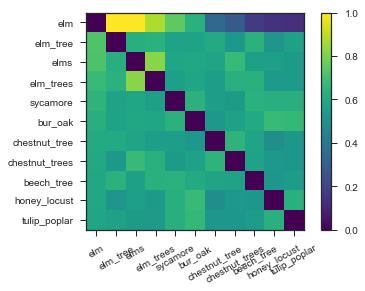

In [527]:
plot_labeled_matrix(g.adj, g.labels)

### Activating random words

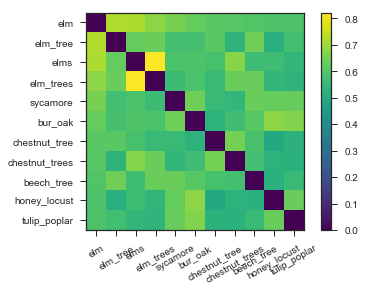

In [528]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

In [529]:
for i in range(200):
    g.activate(np.random.choice(g.labels, 1)[0])

elm at strength 1.0
[ 0.          0.57848651  0.57661122  0.543446    0.52184537  0.50241122
  0.48838317  0.4859219   0.47808486  0.47546935  0.47411919]
elm_tree at strength 0.5784865097260419
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
elms at strength 0.5766112173727699
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
elm_trees at strength 0.5434459967605034
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
sycamore at strength 0.5218453715932225
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
bur_oak at strength 0.5024112183536861
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
chestnut_tree at strength 0.48838317332093184
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
chestnut_trees at strength 0.4859219010083165
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
beech_tree at strength 0.4780848571639153
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
honey_locust at strength 0.4754693509881796
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
tulip_poplar at strength 0.47411918535968056
[ 0.  0.  0.

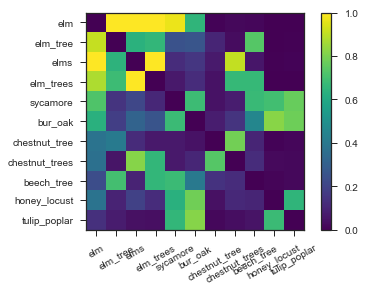

In [530]:
plot_labeled_matrix(g.adj, g.labels)

## Getting reasonable word lists and distance matrices from the Google News corpus

### n clusters of hierarchically related words based on category seeds

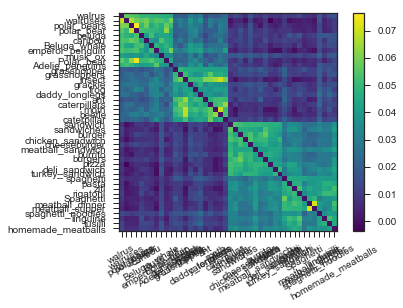

In [350]:
seeds = ['walrus', 'grasshopper', 'sandwich', 'spaghetti']
animals_food = []
for seed in seeds:
    animals_food += connected_word_list(seed, google_news, n_iterations=1)

animals_food_dsm = dist.squareform(semantic_dsm(word_list=animals_food, keyed_vectors=google_news))

animals_food_graph = SemanticGraph(word_dsm=animals_food_dsm, labels=animals_food)
plot_labeled_matrix(animals_food_graph.adj, animals_food_graph.labels)

## Saving and loading word vectors

In [358]:
import json

In [362]:
kv = {word: google_news.word_vec(word).tolist() for word in animals_food}

In [363]:
with open('animals_food.json', 'w') as f:
    json.dump(kv, f)

In [366]:
with open('animals_food.json', 'r') as f:
    kv_loaded = json.load(f)

In [367]:
kv_loaded['walrus']

[-0.047607421875,
 0.1591796875,
 -0.392578125,
 0.057373046875,
 -0.027099609375,
 0.021240234375,
 -0.048583984375,
 -0.0103759765625,
 0.1474609375,
 -0.01336669921875,
 0.1708984375,
 -0.177734375,
 -0.3125,
 -0.005584716796875,
 -0.396484375,
 -0.251953125,
 -0.466796875,
 -0.0634765625,
 -0.20703125,
 -0.28515625,
 -0.3203125,
 -0.171875,
 0.06640625,
 -0.09228515625,
 0.09765625,
 -0.5703125,
 -0.04150390625,
 0.0120849609375,
 0.2373046875,
 -0.07275390625,
 -0.08740234375,
 0.458984375,
 -0.1064453125,
 -0.07421875,
 0.1494140625,
 -0.00946044921875,
 0.16796875,
 0.359375,
 0.26171875,
 -0.1650390625,
 -0.1787109375,
 -0.06494140625,
 0.046630859375,
 0.25390625,
 0.11279296875,
 -0.2470703125,
 -0.0634765625,
 0.001983642578125,
 0.478515625,
 0.0712890625,
 -0.2333984375,
 -0.12890625,
 -0.14453125,
 -0.1865234375,
 0.13671875,
 -0.03173828125,
 -0.11572265625,
 -0.3125,
 0.1337890625,
 -0.34375,
 -0.220703125,
 0.25390625,
 0.1845703125,
 -0.5,
 0.46875,
 -0.474609375,
 0.